# ALTEGRAD challenge Fall 2017
Can you predict whether two short texts have the same meaning?

https://www.kaggle.com/c/altegrad-challenge-fall-17

The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning.

The ground truth is a set of labels supplied by human experts. This is inherently subjective, as the true meaning of sentences can not be known with certainty. Human labeling is a 'noisy' process, and different people would probably disagree. As a result, ground truth labels on this dataset should be taken as indications but not 100% accurate, and may include incorrect labeling.

https://www.kaggle.com/act444/lb-0-158-xgb-handcrafted-leaky
https://github.com/Kulbear/quora-question-pair/tree/master/final_submission
https://www.kaggle.com/c/quora-question-pairs/kernels
https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
https://www.kaggle.com/jturkewitz/magic-features-0-03-gain
https://www.kaggle.com/cpmpml/spell-checker-using-word2vec
https://www.kaggle.com/c/quora-question-pairs/discussion/34355
https://www.kaggle.com/c/quora-question-pairs/discussion/34534
https://github.com/rbauld/kaggle/blob/master/quora_question_pair/Features6.py
http://chaire-dami.fr/files/2017/06/Quora_winning_solution.pdf
https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07
https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

In [ ]:
from gensim.models.word2vec import Word2Vec

In [1]:
# General
import numpy as np
import pandas as pd
import string
from nltk.corpus import stopwords
import re 
import itertools
import operator
import copy
import heapq
import spacy
import nltk
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.spatial.distance import cosine, euclidean, jaccard
import os
import warnings
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from nltk.stem import SnowballStemmer
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from fuzzywuzzy import fuzz
from jellyfish import jaro_distance, jaro_winkler
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

import spacy
from collections import Counter
#spacy.load('en')
#nlp = spacy.load('en')
#nlp = spacy.load('en', parser=False)
nlp = spacy.load('en', disable=['parser'])
#In the default models, the parser is loaded and enabled as part of the standard processing pipeline. 
#If you don't need any of the syntactic information, you should disable the parser. 
#Disabling the parser will make spaCy load and run much faster.

warnings.filterwarnings('ignore')

C:\Users\Jolyanne\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Jolyanne\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Preparation of our data

In [123]:
df_all_texts = pd.read_csv('train.csv', names=['row_ID', 'text_a_ID', 'text_b_ID', 'text_a_text', 'text_b_text', 'target'])
### rajuter traitement stem et stopword sur df_all_texts


In [124]:
train = pd.read_csv('train.csv', names=['row_ID', 'text_a_ID', 'text_b_ID', 'text_a_text', 'text_b_text', 'target'])
train.head()

,row_ID,text_a_ID,text_b_ID,text_a_text,text_b_text,target
0,0,199954,384085,What are the some of the best novels?,What are some of the greatest novels of all ti...,0
1,1,128681,237407,What are the pictures that made you look twice?,What are some amazing pictures one has to see ...,0
2,2,170846,240621,Have the ellectoral college members ever voted...,When has the electoral college voted against t...,1
3,3,55110,177468,Did Ravana really have 10 heads?,Why did Ravana have 10 heads?,1
4,4,425513,400256,What's a book that you feel helped you to impr...,What books or magazines should I read to impro...,0


In [125]:
train.shape

(80100, 6)

In [126]:
train, test = train_test_split(train, test_size = 0.3)

In [127]:
train.shape

(56070, 6)

In [128]:
test.shape

(24030, 6)

In [129]:
# real test data with no labels
real_test = pd.read_csv('test.csv', names=['row_ID', 'text_a_ID', 'text_b_ID', 'text_a_text', 'text_b_text', 'target'])
real_test.shape

(20179, 6)

# cleaning

In [9]:
def clean_text_simple(text, remove_stopwords=True, pos_filtering=True, stemming=True):
    #print(text)
    english_stopwords = set([stopword for stopword in stopwords.words('english')])
    punct = set(string.punctuation)
    punct.update(["``", "`", "..."])
    text = text.lower()
    text = ''.join(l for l in text if l not in punct) # remove punctuation (preserving intra-word dashes)
    text = re.sub(' +',' ',text) # strip extra white space
    text = text.strip() # strip leading and trailing white space
    # tokenize (split based on whitespace)
    tokens = text.split(' ')
    if pos_filtering == True:
        # POS tag and retain only nouns and adjectives
        tagged_tokens = pos_tag(tokens)
        tokens_keep = []
        for item in tagged_tokens:
            if (
            item[1] == 'NN' or
            item[1] == 'NNS' or
            item[1] == 'NNP' or
            item[1] == 'NNPS' or
            item[1] == 'JJ' or
            item[1] == 'JJS' or
            item[1] == 'JJR'
            ):
                tokens_keep.append(item[0])
        tokens = tokens_keep
    if remove_stopwords:
        # remove stopwords
        tokens = [token for token in tokens if token not in english_stopwords and len(token)>1]
    if stemming:
        # apply Porter's stemmer
        stemmer = nltk.stem.PorterStemmer()
        tokens_stemmed = list()
        for token in tokens:
            tokens_stemmed.append(stemmer.stem(token))
        tokens = tokens_stemmed
    
    return(' '.join(tokens))

### Construction of pairs ans texts array

In [10]:
def construct_pairs(train, test, remove_stopwords= True, pos_filtering=False, stemming = True):
    texts = {}
    pairs_train = []
    pairs_test = []
    y_train = []
    y_true = []
    ids2ind = {} # will contain the row idx of each unique text in the TFIDF matrix 

    for idx, l in enumerate(train.values):
        if l[1] not in texts:
            texts[l[1]] = clean_text_simple(l[3], remove_stopwords = remove_stopwords, 
                                            pos_filtering = pos_filtering, 
                                            stemming = stemming)
            
        if l[2] not in texts:
            texts[l[2]] = clean_text_simple(l[4], remove_stopwords = remove_stopwords, 
                                            pos_filtering = pos_filtering, 
                                            stemming = stemming)

        pairs_train.append([l[1], l[2]])
        y_train.append(int(l[5]))

    for idx, l in enumerate(test.values):
        if l[1] not in texts:
            texts[l[1]] = clean_text_simple(l[3], remove_stopwords = remove_stopwords, 
                                            pos_filtering = pos_filtering, 
                                            stemming = stemming)
            
        if l[2] not in texts:
            texts[l[2]] = clean_text_simple(l[4], remove_stopwords = remove_stopwords, 
                                            pos_filtering = pos_filtering, 
                                            stemming = stemming)

        pairs_test.append([l[1], l[2]])
        y_true.append(int(l[5])) 
        
    for qid in texts:
        ids2ind[qid] = len(ids2ind)
    
    return texts,pairs_train, pairs_test, y_train, y_true, ids2ind

## Features engineering 

### Tf-Idf

In [11]:
def tfIdf(texts):
    return TfidfVectorizer().fit_transform(texts.values())

### Spacy tags
https://spacy.io/usage/linguistic-features

In [12]:
def spacy_tag(sentence):
    sentence = nlp(sentence)
    count_tags = Counter([w.pos_ for w in sentence])
    return count_tags

In [13]:
def similarity(count_tags1, count_tags2):
    bag_of_tags1 = list(count_tags1.keys())
    #print(bag_of_tags1)
    bag_of_tags_values1 = [count_tags1.get(l) for l in bag_of_tags1]
    #print(bag_of_tags_values1)
    bag_of_tags2 = list(count_tags2.keys())
    #print(bag_of_tags2)
    bag_of_tags_values2 = [count_tags2.get(l) for l in bag_of_tags2]
    #print(bag_of_tags_values2)
    
    everseen = list()
    diff = 0
    for i, tag in enumerate(bag_of_tags1):
        if tag in bag_of_tags2:
            everseen.append(tag)
            index = bag_of_tags2.index(tag)
            diff = diff + np.abs(bag_of_tags_values1[i] - bag_of_tags_values2[index])
        else :
            everseen.append(tag)
            diff = diff + bag_of_tags_values1[i]
    
    for i, tag in enumerate(bag_of_tags2):
        if tag not in everseen:
            everseen.append(tag)
            diff = diff + bag_of_tags_values2[i]
    #print(diff)        
    #return diff / len(everseen)
    return diff / (np.sum(bag_of_tags_values1) + np.sum(bag_of_tags_values2)) # We normalize

### Numbers of Words in common and difference between 2 questions 

In [14]:
def common_words(q1, q2):
    q1 = q1.split(' ')
    q2 = q2.split(' ')
    everseen = list()
    common = 0
    for i, tag in enumerate(q1):
        if tag in q2:
            everseen.append(tag)
            common = common + 1
        else :
            everseen.append(tag)
    return common
    
def diff_words(q1, q2):
    q1 = q1.split(' ')
    q2 = q2.split(' ')
    everseen = list()
    diff = 0
    for tag in q1:
        if tag not in q2:
            everseen.append(tag)
            diff = diff + 1
        else :
            everseen.append(tag)          
    for tag in q2:
        if tag not in (everseen and q2):
            everseen.append(tag)
            diff = diff + 1
    return diff

### Fuzzy String Matching
Calculate edit distances between each question pair (Levenshtein, Jaro, Jaro-Winkler, ...).


In [15]:
def fuzzy(q1_text, q2_text):   
    q1_tokens=q1_text.split()
    q2_tokens=q2_text.split()
    fuzzy_distances = np.array([
        fuzz.ratio(q1_tokens, q2_tokens),
        fuzz.partial_ratio(q1_tokens, q2_tokens),
        fuzz.token_sort_ratio(q1_tokens, q2_tokens),
        fuzz.token_set_ratio(q1_tokens, q2_tokens),
        fuzz.partial_token_sort_ratio(q1_tokens, q2_tokens),
    ], dtype='float')
    
    # Normalize to [0 - 1] range.
    fuzzy_distances /= 100
    
    jelly_distances = np.array([
        jaro_distance(q1_text, q2_text),
        jaro_winkler(q1_text, q2_text),
    ])
    
    return np.concatenate([fuzzy_distances, jelly_distances])

### Character N-Gram Jaccard Index
Calculate Jaccard similarities between sets of character $n$-grams for different values of $n$.

In [16]:
NGRAM_RANGE = range(2, 6)

def get_char_ngrams(doc, n):
    return [doc[i:i + n] for i in range(len(doc) - n + 1)]

def get_jaccard_set_similarities(a, b):
    len_intersection = len(a.intersection(b))
    jaccard_index = len_intersection / len(a.union(b))
    jaccard_index_norm_a = len_intersection / len(a)
    jaccard_index_norm_b = len_intersection / len(b)
    
    return jaccard_index, jaccard_index_norm_a, jaccard_index_norm_b

def get_jaccard_similarities(q1, q2, n):
    if len(q1) < max(NGRAM_RANGE) and len(q2) < max(NGRAM_RANGE):
        return 1, 1, 1
    if len(q1) < max(NGRAM_RANGE) or len(q2) < max(NGRAM_RANGE):
        return 0, 0, 0
    
    q1_ngrams = set(get_char_ngrams(q1, n))
    q2_ngrams = set(get_char_ngrams(q2, n))
    return get_jaccard_set_similarities(q1_ngrams, q2_ngrams)

def get_question_pair_features(q1,q2):
    
    features = []
    for n in NGRAM_RANGE:
        features.extend(get_jaccard_similarities(q1, q2, n))
    
    return features
#a=get_question_pair_features("bonjour petit chat noir","salut petit chien blanc" )
#a


### LDA Topic Distances
Train a Latent Dirichlet Allocation model with 300 topics on the question corpus and compute topic distances between the question pairs.
https://github.com/YuriyGuts/kaggle-quora-question-pairs/blob/master/notebooks/feature-lda.ipynb

In [17]:
def stem_pair(pair):
    stemmer = SnowballStemmer('english')
    return [
        [stemmer.stem(token) for token in texts[pair[0]].split()],
        [stemmer.stem(token) for token in texts[pair[1]].split()],
    ]

def compute_topic_distances(q1, q2, lda_dictionary, model):
    
    q1_bow = lda_dictionary.doc2bow(q1)
    q2_bow = lda_dictionary.doc2bow(q2)
    
    q1_topic_vec = np.array(model.get_document_topics(q1_bow, minimum_probability=0))[:, 1].reshape(1, -1)
    q2_topic_vec = np.array(model.get_document_topics(q2_bow, minimum_probability=0))[:, 1].reshape(1, -1)
    
    return [
        cosine_distances(q1_topic_vec, q2_topic_vec)[0][0],
        euclidean_distances(q1_topic_vec, q2_topic_vec)[0][0],
    ]

In [36]:
def lda_init(pairs_train, pairs_test, df_all_texts):
    NUM_TOPICS = 300
    RANDOM_SEED = 42
    #stemmer = SnowballStemmer('english')

    lda_tokens = list()

    for i in range(len(pairs_train)):
        lda_tokens.append(stem_pair(pairs_train[i]))
    for i in range(len(pairs_test)):
        lda_tokens.append(stem_pair(pairs_test[i]))

    lda_documents = list(np.array(lda_tokens).ravel()) #When a view is desired, arr.reshape(-1) may be preferable.
    lda_dictionary = Dictionary(lda_documents)
    lda_corpus = [lda_dictionary.doc2bow(document) for document in lda_documents]

    model = LdaMulticore(
        lda_corpus,
        num_topics=NUM_TOPICS,
        id2word=lda_dictionary,
        random_state=RANDOM_SEED,
    )

    lda_distances = list()
    for i in lda_tokens:
        lda_distances.append(compute_topic_distances(i[0], i[1],lda_dictionary, model))

    lda_train = np.array(lda_distances[:len(pairs_train)], dtype='float64')
    lda_test = np.array(lda_distances[len(pairs_train):], dtype='float64')
    
    columns_lda=['lda_1','lda_2']
    lda_distances = pd.DataFrame(
    lda_distances,
    columns=columns_lda
    )

    lda_df = pd.concat([lda_distances, df_all_texts['text_a_ID'], df_all_texts['text_b_ID'] ], axis=1)
    return lda_df
    

In [19]:
def get_lda(q1,q2, lda_df):
    
    raw = lda_df[lda_df['text_a_ID'] == q1][lda_df[lda_df['text_a_ID'] == q1]['text_b_ID'] == q2]
    raw1 = lda_df[lda_df['text_a_ID'] == q2][lda_df[lda_df['text_a_ID'] == q2]['text_b_ID'] == q1]

    if(raw1.empty): return raw
    elif(raw.empty): return raw1
    else: return 0

### POS/NER Tag Similarity
Derive bag-of-POS-tag (part of speech tagging) and bag-of-NER-tag (Named Entity Recognition) vectors from each question and calculate their vector distances.

(POS) https://spacy.io/usage/linguistic-features#pos-tagging

(NER) https://spacy.io/usage/linguistic-features#named-entities


to see the meaning of tags: https://spacy.io/api/annotation#pos-tagging

(NER) labels sequences of words in a text which are the names of things, such as person and company names, or gene and protein names.

In [20]:
def create_counter(name, df_all_texts, num_raw_features, pos_tags_whitelist, ner_tags_whitelist):
    
    X1 = np.zeros((len(df_all_texts), num_raw_features))
    pipe_q1 = nlp.pipe(df_all_texts[name].values, n_threads=os.cpu_count())

    for i, doc in enumerate(pipe_q1):
        pos_counter = Counter(token.pos_ for token in doc)
        ner_counter = Counter(ent.label_ for ent in doc.ents)
        X1[i, :] = np.array(
            [pos_counter[pos_tag] for pos_tag in pos_tags_whitelist] +
            [ner_counter[ner_tag] for ner_tag in ner_tags_whitelist]
        )
    return X1

def get_vector_distances(i, X1, X2, pos_tags_whitelist, ner_tags_whitelist):
    return [
        # POS distances.
        cosine(X1[i, 0:len(pos_tags_whitelist)], X2[i, 0:len(pos_tags_whitelist)]),
        euclidean(X1[i, 0:len(pos_tags_whitelist)], X2[i, 0:len(pos_tags_whitelist)]),

        # NER distances.
        euclidean(X1[i, -len(ner_tags_whitelist):], X2[i, -len(ner_tags_whitelist):]),
        np.abs(np.sum(X1[i, -len(ner_tags_whitelist):]) - np.sum(X2[i, -len(ner_tags_whitelist):])),
    ]

In [21]:
def pos_ner_tags(df_all_texts):
    pos_tags_whitelist = ['ADJ', 'ADV', 'NOUN', 'PROPN', 'NUM', 'VERB']
    ner_tags_whitelist = ['GPE', 'LOC', 'ORG', 'NORP', 'PERSON', 'PRODUCT', 'DATE', 'TIME', 'QUANTITY', 'CARDINAL']

    num_raw_features = len(pos_tags_whitelist) + len(ner_tags_whitelist)

    X1 = create_counter('text_a_text', df_all_texts, num_raw_features, pos_tags_whitelist, ner_tags_whitelist)
    X2 = create_counter('text_b_text', df_all_texts, num_raw_features, pos_tags_whitelist, ner_tags_whitelist)

    df_pos_q1 = pd.DataFrame(
        X1[:, 0:len(pos_tags_whitelist)],
        columns=['pos_q1_' + pos_tag.lower() for pos_tag in pos_tags_whitelist])
    df_pos_q2 = pd.DataFrame(
        X2[:, 0:len(pos_tags_whitelist)],
        columns=['pos_q2_' + pos_tag.lower() for pos_tag in pos_tags_whitelist])
    df_ner_q1 = pd.DataFrame(
        X1[:, -len(ner_tags_whitelist):],
        columns=['ner_q1_' + ner_tag.lower() for ner_tag in ner_tags_whitelist])
    df_ner_q2 = pd.DataFrame(
        X2[:, -len(ner_tags_whitelist):],
        columns=['ner_q2_' + ner_tag.lower() for ner_tag in ner_tags_whitelist])
    
    
    tags_distances = list()
    for i in list(range(len(df_all_texts))):
        tags_distances.append(get_vector_distances(i,X1, X2, pos_tags_whitelist, ner_tags_whitelist))

    tags_columns=[
            'pos_tag_cosine',
            'pos_tag_euclidean',
            'ner_tag_euclidean',
            'ner_tag_count_diff',
        ]

    tags_distances = pd.DataFrame(tags_distances, columns = tags_columns)
    df_tags = pd.concat([tags_distances, df_all_texts['text_a_ID'], df_all_texts['text_b_ID'] ], axis=1)
    return df_tags

In [22]:
def get_tags(q1, q2, df_tags):
    raw = df_tags[df_tags['text_a_ID'] == q1][df_tags[df_tags['text_a_ID'] == q1]['text_b_ID'] == q2]
    raw1 = df_tags[df_tags['text_a_ID'] == q2][df_tags[df_tags['text_a_ID'] == q2]['text_b_ID'] == q1]

    if(raw1.empty): return raw
    elif(raw.empty): return raw1
    else: return 0

#### frequency of questions

more frequent questions are more likely to have the same meaning ?

In [23]:
def compute_question_freq(train, test):

    df1 = train[['text_a_text']].copy()
    df2 = train[['text_b_text']].copy()
    df1_test = test[['text_a_text']].copy()
    df2_test = test[['text_b_text']].copy()

    df2.rename(columns = {'question2':'question1'},inplace=True)
    df2_test.rename(columns = {'question2':'question1'},inplace=True)

    train_questions = df1.append(df2)
    train_questions = train_questions.append(df1_test)
    train_questions = train_questions.append(df2_test)
    train_questions.drop_duplicates(subset = ['text_a_text'],inplace=True)
    train_questions.reset_index(inplace=True,drop=True)
    questions_dict = pd.Series(train_questions.index.values,index=train_questions.text_a_text.values).to_dict()

    train_cp = train.copy()
    test_cp = test.copy()
    train_cp.drop(['text_a_ID','text_b_ID'],axis=1,inplace=True)
    test_cp.drop(['text_a_ID','text_b_ID'],axis=1,inplace=True)
    test_cp['target'] = -1
    #test_cp.rename(columns={'row_ID':'id'},inplace=True)

    comb = pd.concat([train_cp,test_cp])
    comb['q1_hash'] = comb['text_a_text'].map(questions_dict)
    comb['q2_hash'] = comb['text_b_text'].map(questions_dict)

    q1_vc = comb.q1_hash.value_counts().to_dict()
    q2_vc = comb.q2_hash.value_counts().to_dict()

    def try_apply_dict(x,dict_to_apply):
        try:
            return dict_to_apply[x]
        except KeyError:
            return 0

    comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
    comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

    train_comb = comb[comb['target'] >= 0][['row_ID','q1_hash','q2_hash','q1_freq','q2_freq','target']]
    test_comb = comb[comb['target'] < 0][['row_ID','q1_hash','q2_hash','q1_freq','q2_freq']]

    #corr_mat = train_comb.corr()
    #corr_mat.head()
    
    train_comb.reset_index(inplace=True,drop=True)
    test_comb.reset_index(inplace=True,drop=True)

    return train_comb.sort_index(), test_comb.sort_index()
    #return train_comb, test_comb

#train_freq, test_freq = compute_question_freq(train, test)
#train_freq.head()
#train.loc[train['row_ID']== 26790]

ss

In [140]:
def word_match_share(q1, q2):
    stops = set([stopword for stopword in stopwords.words('english')])
    q1words = {}
    q2words = {}
    for word in q1:
        if word not in stops:
            q1words[word] = 1
    for word in q2:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

def jaccard(q1, q2):
    wic = set(q1).intersection(set(q2))
    uw = set(q1).union(q2)
    if len(uw) == 0:
        uw = [1]
    return (len(wic) / len(uw))

def common_words(q1, q2):
    return len(set(q1).intersection(set(q2)))

def total_unique_words(q1, q2):
    return len(set(q1).union(q2))

def total_unq_words_stop(q1, q2):
    stops = set([stopword for stopword in stopwords.words('english')])
    return len([x for x in set(q1).union(q2) if x not in stops])

def wc_diff(q1, q2):
    return abs(len(q1) - len(q2))

def wc_ratio(q1, q2):
    l1 = len(q1)*1.0 
    l2 = len(q2)
    if l2 == 0:
        return np.nan
    if l1 / l2:
        return l2 / l1
    else:
        return l1 / l2
    
def wc_diff_unique(q1, q2):
    return abs(len(set(q1)) - len(set(q2)))

def wc_ratio_unique(q1, q2):
    l1 = len(set(q1)) * 1.0
    l2 = len(set(q2))
    if l2 == 0:
        return np.nan
    if l1 / l2:
        return l2 / l1
    else:
        return l1 / l2

def wc_diff_unique_stop(q1, q2):
    stops = set([stopword for stopword in stopwords.words('english')])
    return abs(len([x for x in set(q1) if x not in stops]) - len([x for x in set(q2) if x not in stops]))

def wc_ratio_unique_stop(q1, q2):
    stops = set([stopword for stopword in stopwords.words('english')])
    l1 = len([x for x in set(q1) if x not in stops])*1.0 
    l2 = len([x for x in set(q2) if x not in stops])
    if l2 == 0:
        return np.nan
    if l1 / l2:
        return l2 / l1
    else:
        return l1 / l2

def same_start_word(q1, q2):
    if not q1 or not q2:
        return np.nan
    return int(q1[0] == q2[0])

def char_diff(q1, q2):
    return abs(len(''.join(q1)) - len(''.join(q2)))

def char_ratio(q1, q2):
    l1 = len(''.join(q1)) 
    l2 = len(''.join(q2))
    if l2 == 0:
        return np.nan
    if l1 / l2:
        return l2 / l1
    else:
        return l1 / l2

def char_diff_unique_stop(q1, q2):
    stops = set([stopword for stopword in stopwords.words('english')])
    return abs(len(''.join([x for x in set(q1) if x not in stops])) - len(''.join([x for x in set(q2) if x not in stops])))


def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)


def tfidf_word_match_share_stops(row, weights=None):
    stops = set([stopword for stopword in stopwords.words('english')])
    q1words = {}
    q2words = {}
    for word in row['question1']:
        if word not in stops:
            q1words[word] = 1
    for word in row['question2']:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

def tfidf_word_match_share(q1, q2, weights=None):
    q1words = {}
    q2words = {}
    for word in q1:
        q1words[word] = 1
    for word in q2:
        q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

### We save into csv files some features in case of problem

In [131]:
def save_lda_df(lda_df, name):
    with open(name, 'w') as f:
        f.write("lda_1,lda_2,text_a_ID,text_b_ID\n")
        for i in range(len(lda_df)):
            f.write(str(lda_df['lda_1'][i])
                    +','
                    +str(lda_df['lda_2'][i])
                    +','
                    +str(lda_df['text_a_ID'][i])
                    +','
                    +str(lda_df['text_b_ID'][i])+'\n')

In [132]:
def save_df_tags(df_tags, name):
    with open(name, 'w') as f:
        f.write("pos_tag_cosine,pos_tag_euclidean,ner_tag_euclidean,ner_tag_count_diff,text_a_ID,text_b_ID\n")
        for i in range(len(df_tags)):
            f.write(str(df_tags['pos_tag_cosine'][i])
                    +','
                    +str(df_tags['pos_tag_euclidean'][i])
                    +','
                    +str(df_tags['ner_tag_euclidean'][i])
                    +','
                    +str(df_tags['ner_tag_count_diff'][i])
                    +','
                    +str(df_tags['text_a_ID'][i])
                    +','
                    +str(df_tags['text_b_ID'][i])+'\n')

### Build the features

In [133]:
# features name
features=['cosine similarity (CS)',
          'total length (TL)', 
          'difference length (DL)',
          'sim pos tags (POS)', 
          'POS*DL',
          'POS*TL', 
          'POS*POS*TL',
          'POS*POS*DL',
          'common words (CW)', 
          'CW*POS','CW*POS*DL',
          'CW*POS*TL',
          'fuzz ratio',
          'fuzz partial_ratio',
          'fuzz token_sort_ratio',
          'fuzz token_set_ratio',
          'fuzz partial_token_sort_ratio',
          'jaro_distance',
          'jaro_winkler',
          'jaccard_index n=2',
          'jaccard_index_norm_a n=2',
          'jaccard_index_norm_b n=2',
          'jaccard_index n=3',
          'jaccard_index_norm_a n=3', 
          'jaccard_index_norm_b n=3',
          'jaccard_index n=4', 
          'jaccard_index_norm_a n=4', 
          'jaccard_index_norm_b n=4',
          'jaccard_index n=5', 
          'jaccard_index_norm_a n=5', 
          'jaccard_index_norm_b n=5',
          'pos_tag_cosine',
          'pos_tag_euclidean',
          'ner_tag_euclidean',
          'ner_tag_count_diff',
          'diff_words',
          'lda_1',
          'lda_2',
          'common_diff',
          'common_min',
          'common_max',
          'mean_l',
          'same_last',
          'same_first',
          'freq_q1',
          'freq_q2',
         '1','2','3','4','5','1','2','3','4','5','1','2','3','4','5']

In [141]:
# faire varier la construction des pairs avec steeming, ...
def construct_data(pairs_train, A, lda_df, df_tags, train_freq):
    
    N_train = len(pairs_train)
    X_train = np.zeros((N_train, 61))
    SAFE_DIV = 0.0001

    for i in range(N_train):
        if i%1000 == 0: print(i) #pour suivre la progression
            
        q1 = pairs_train[i][0]
        q2 = pairs_train[i][1]
        
        X_train[i, 0] = cosine_similarity(A[ids2ind[q1], :], A[ids2ind[q2], :])  
        X_train[i, 1] = len(texts[q1]) + len(texts[q2])
        X_train[i, 2] = abs(len(texts[q1]) - len(texts[q2])) 
        
        X_train[i, 3] = similarity(spacy_tag(texts[q1]), spacy_tag(texts[q2])) # similarity on spacy tag: noun, verb, ...
        X_train[i, 4] = X_train[i, 2] * X_train[i, 3]
        X_train[i, 5] = X_train[i, 1] * X_train[i, 3]
        X_train[i, 6] = X_train[i, 5] * X_train[i, 3]
        X_train[i, 7] = X_train[i, 4] * X_train[i, 3]
        
        X_train[i, 8] = common_words(texts[q1], texts[q2]) # number of words in common
        X_train[i, 9] = X_train[i, 8] * X_train[i, 3]
        X_train[i, 10] = X_train[i, 8] * X_train[i, 4]
        X_train[i, 11] = X_train[i, 8] * X_train[i, 5]
        
        a = fuzzy(texts[q1], texts[q2])
        for j in range(7):
            X_train[i, 12 + j] = a[j]
            
        b = get_question_pair_features(texts[q1], texts[q2])
        for j in range(12):
            X_train[i, 19 + j] = b[j]
            
        c = get_tags(q1, q2, df_tags)
        tags_columns=[
            'pos_tag_cosine',
            'pos_tag_euclidean',
            'ner_tag_euclidean',
            'ner_tag_count_diff',
        ]
        for j in range(4):
            X_train[i, 31 + j] = c[tags_columns[j]]
            
        X_train[i, 35] = diff_words(texts[q1], texts[q2]) # different number of words aussi égal à: X_train[i, 1] - X_train[i, 8]
    
        columns_lda=['lda_1','lda_2']
        d = get_lda(q1, q2, lda_df)
        for j in range(2):
            X_train[i, 36 + j] = d[columns_lda[j]]
            
        X_train[i, 38] = X_train[i, 8] / (X_train[i, 35] + SAFE_DIV) # ratio nb words in common, nb words differents
        X_train[i, 39] = X_train[i, 8] / (min(len(texts[q1].split()), len(texts[q2].split())) + SAFE_DIV) # common on min
        X_train[i, 40] = X_train[i, 8] / (max(len(texts[q1].split()), len(texts[q2].split())) + SAFE_DIV) # common on max
        X_train[i, 41] = (len(texts[q1].split()) + len(texts[q2].split()))/2 # mean lenght of words
        
        if len(texts[q1].split()) != 0 and len(texts[q2].split()) != 0:
            X_train[i, 42] = int(texts[q1].split()[-1] == texts[q2].split()[-1]) # same last word
            X_train[i, 43] = int(texts[q1].split()[0] == texts[q2].split()[0]) # same first word
            
        X_train[i, 44] = train_freq.loc[i]['q1_freq']
        X_train[i, 45] = train_freq.loc[i]['q2_freq']
        
        X_train[i, 46] = word_match_share(texts[q1].split(), texts[q2].split())
        X_train[i, 47] = jaccard(texts[q1].split(), texts[q2].split())
        X_train[i, 48] = common_words(texts[q1].split(), texts[q2].split())
        X_train[i, 49] = total_unique_words(texts[q1].split(), texts[q2].split())
        X_train[i, 50] = total_unq_words_stop(texts[q1].split(), texts[q2].split())
        X_train[i, 51] = wc_diff(texts[q1].split(), texts[q2].split())
        X_train[i, 52] = wc_ratio(texts[q1].split(), texts[q2].split())
        X_train[i, 53] = wc_diff_unique(texts[q1].split(), texts[q2].split())
        X_train[i, 54] = wc_ratio_unique(texts[q1].split(), texts[q2].split())
        X_train[i, 55] = wc_diff_unique_stop(texts[q1].split(), texts[q2].split())
        X_train[i, 56] = wc_ratio_unique_stop(texts[q1].split(), texts[q2].split())
        X_train[i, 57] = same_start_word(texts[q1].split(), texts[q2].split())
        X_train[i, 58] = char_diff(texts[q1].split(), texts[q2].split())
        X_train[i, 59] = char_ratio(texts[q1].split(), texts[q2].split())
        X_train[i, 60] = char_diff_unique_stop(texts[q1].split(), texts[q2].split())

          
    return X_train

In [135]:
print('Pairs construction')
texts, pairs_train, pairs_test, y_train, y_true, ids2ind = construct_pairs(train, 
                                                                          test, 
                                                                          remove_stopwords = True, 
                                                                          pos_filtering = False, 
                                                                          stemming = True)

Pairs construction


In [136]:
print('A')
A = tfIdf(texts)

A


In [ ]:
print('lda')
lda_df = lda_init(pairs_train, pairs_test, df_all_texts)
save_lda_df(lda_df, "lda_df.csv")

In [ ]:
print('tags')
df_tags = pos_ner_tags(df_all_texts)
save_df_tags(df_tags,"df_tags.csv")

In [137]:
print('freq')
train_freq, test_freq = compute_question_freq(train, test)

freq


In [142]:
lda_df= pd.read_csv('lda_df.csv')
df_tags = pd.read_csv('df_tags.csv')

print('Features construction')
X_train = construct_data(pairs_train, A, lda_df, df_tags, train_freq)
X_test = construct_data(pairs_test, A, lda_df, df_tags, test_freq)

Features construction
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [143]:
import csv
pd.DataFrame(X_train).to_csv('X_train_processed.csv', index=False, header=True)
pd.DataFrame(X_test).to_csv('X_test_processed.csv', index=False, header=True)
pd.DataFrame(y_train).to_csv('y_train_processed.csv', index=False, header=False)
pd.DataFrame(y_true).to_csv('y_test_processed.csv', index=False, header=False)

### We explore our data

Si on doit supprimer des features, on le fait ici comme ça on recalcule pas tout

In [144]:
df_X_train = pd.DataFrame(X_train, columns = features)
df_X_train.head()

,cosine similarity (CS),total length (TL),difference length (DL),sim pos tags (POS),POS*DL,POS*TL,POS*POS*TL,POS*POS*DL,common words (CW),CW*POS,...,1,2,3,4,5,1,2,3,4,5
0,0.648169,31.0,5.0,0.428571,2.142857,13.285714,5.693878,0.918367,7.0,3.000000,...,1.0,0.75,1.0,0.75,1.0,0.75,0.0,4.0,0.733333,4.0
1,1.000000,22.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,10.0,0.000000,...,0.0,1.00,0.0,1.00,0.0,1.00,1.0,0.0,1.000000,0.0
2,0.798655,35.0,13.0,0.333333,4.333333,11.666667,3.888889,1.444444,8.0,2.666667,...,2.0,0.50,2.0,0.50,2.0,0.50,0.0,11.0,0.476190,11.0
3,0.416006,51.0,11.0,0.111111,1.222222,5.666667,0.629630,0.135802,9.0,1.000000,...,1.0,1.25,1.0,1.25,1.0,1.25,0.0,10.0,1.588235,10.0
4,0.705351,31.0,1.0,0.333333,0.333333,10.333333,3.444444,0.111111,8.0,2.666667,...,0.0,1.00,0.0,1.00,0.0,1.00,1.0,1.0,0.928571,1.0


In [145]:
df_X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
cosine similarity (CS),56070.0,0.597075,0.228375,0.000000e+00,0.439604,0.608753,0.767671,1.000000
total length (TL),56070.0,58.328500,25.440741,0.000000e+00,40.000000,53.000000,71.000000,233.000000
difference length (DL),56070.0,8.778794,9.497150,0.000000e+00,2.000000,6.000000,12.000000,146.000000
sim pos tags (POS),56067.0,0.258185,0.184302,0.000000e+00,0.125000,0.250000,0.333333,1.000000
POS*DL,56067.0,2.981948,4.816185,0.000000e+00,0.363636,1.285714,3.600000,100.375000
POS*TL,56067.0,14.939962,12.324250,0.000000e+00,5.857143,12.500000,21.000000,140.250000
POS*POS*TL,56067.0,5.627731,7.202605,0.000000e+00,0.775510,3.111111,7.714286,99.049887
POS*POS*DL,56067.0,1.268223,2.857248,0.000000e+00,0.057851,0.297521,1.250000,69.007812
common words (CW),56070.0,12.266827,3.156652,0.000000e+00,10.000000,12.000000,14.000000,24.000000
CW*POS,56067.0,3.032283,2.132253,0.000000e+00,1.500000,2.800000,4.333333,15.000000


In [146]:
df_X_test = pd.DataFrame(X_test, columns = features)
df_X_test.head()

,cosine similarity (CS),total length (TL),difference length (DL),sim pos tags (POS),POS*DL,POS*TL,POS*POS*TL,POS*POS*DL,common words (CW),CW*POS,...,1,2,3,4,5,1,2,3,4,5
0,0.505996,116.0,16.0,0.333333,5.333333,38.666667,12.888889,1.777778,16.0,5.333333,...,2.0,1.25,2.0,1.25,2.0,1.25,0.0,14.0,1.325581,14.0
1,0.626199,57.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,14.0,0.000000,...,0.0,1.00,0.0,1.00,0.0,1.00,0.0,1.0,1.041667,1.0
2,0.543760,34.0,4.0,0.600000,2.400000,20.400000,12.240000,1.440000,9.0,5.400000,...,1.0,1.50,1.0,1.50,1.0,1.50,0.0,3.0,1.214286,3.0
3,0.788589,66.0,2.0,0.200000,0.400000,13.200000,2.640000,0.080000,15.0,3.000000,...,0.0,1.00,0.0,1.00,0.0,1.00,1.0,2.0,1.071429,2.0
4,0.453056,65.0,5.0,0.166667,0.833333,10.833333,1.805556,0.138889,13.0,2.166667,...,1.0,1.20,1.0,1.20,1.0,1.20,0.0,4.0,1.153846,4.0


In [147]:
df_X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
cosine similarity (CS),24030.0,0.595348,0.228124,0.000000e+00,0.441623,0.608951,0.764798,1.000000
total length (TL),24030.0,58.411319,25.435553,0.000000e+00,40.000000,53.000000,71.000000,204.000000
difference length (DL),24030.0,8.765959,9.452334,0.000000e+00,2.000000,6.000000,12.000000,105.000000
sim pos tags (POS),24029.0,0.260211,0.184285,0.000000e+00,0.142857,0.250000,0.333333,1.000000
POS*DL,24029.0,2.992384,4.852433,0.000000e+00,0.363636,1.285714,3.666667,73.913043
POS*TL,24029.0,15.042624,12.267044,0.000000e+00,5.909091,12.555556,21.230769,108.818182
POS*POS*TL,24029.0,5.681885,7.214705,0.000000e+00,0.795918,3.125000,7.888889,77.854671
POS*POS*DL,24029.0,1.282170,2.934638,0.000000e+00,0.059172,0.305556,1.264463,54.631380
common words (CW),24030.0,12.262256,3.155884,0.000000e+00,10.000000,12.000000,14.000000,25.000000
CW*POS,24029.0,3.052218,2.126148,0.000000e+00,1.555556,2.833333,4.363636,13.538462


In [148]:
def mean_normalize_all_features(df):
    return (df-df.mean())/df.std()

In [47]:
def minmax_normalize_all_features(df):
    return (df-df.min())/(df.max()-df.min())

In [48]:
df_X_train_mean_norm = mean_normalize_all_features(df_X_train.copy())
df_X_test_mean_norm = mean_normalize_all_features(df_X_test.copy())

df_X_train_minmax_norm = minmax_normalize_all_features(df_X_train.copy())
df_X_test_minmax_norm = minmax_normalize_all_features(df_X_test.copy())

In [49]:
def del_features(matrice, index):
    for i in index:
        matrice = np.delete(matrice,i,axis=1)
    return matrice

### Classifier

(tester plrs modèles mais xgboost devrait etre le meilleur)

sinon voir pour réseaux de neurones (modèles siamois, cnn, ...)

#### SVC

In [50]:
#X_train= pd.read_csv('X_train_processed.csv')
#X_test = pd.read_csv('X_test_processed.csv')

#### Xgboost 

http://xgboost.readthedocs.io/en/latest/python/python_intro.html

In [149]:
def threshold(y_pred):
    return [1 if y >= 0.5 else 0 for y in y_pred]

# read in data
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

#### voir pour un grid search
# specify parameters via map
param = {'max_depth': 6, 'eta':0.1, 'silent':1, "objective" : "binary:logistic", "eval_metric": "logloss"}
num_round = 309
bst = xgb.train(param, dtrain, num_round)

# make prediction
y_pred = bst.predict(dtest)
#print(y_pred)

#acc = accuracy_score(y_true, threshold(y_pred))
#print("accuracy =" + str(acc))

loss = log_loss(y_true, y_pred, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("cross entropy = " + str(loss)) # the mean loss per sample.

cross entropy = 0.32702802205


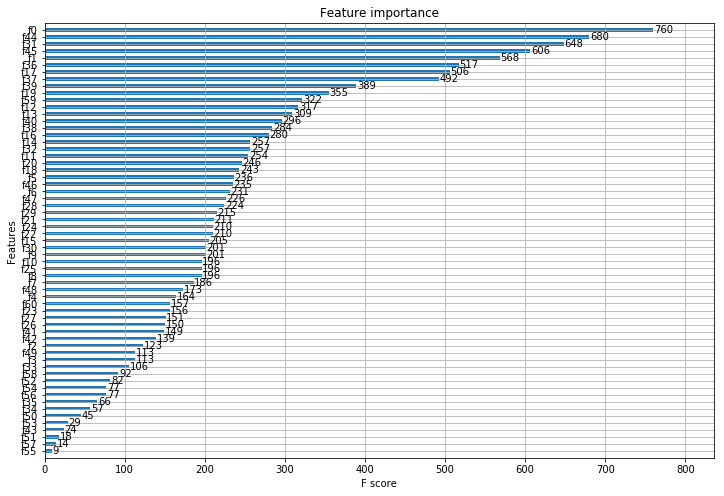

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline 

fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(bst, height=0.5, ax=ax)
plt.show()

##### mean normalized data

In [67]:
dtrain = xgb.DMatrix(df_X_train_mean_norm, label = y_train)
dtest = xgb.DMatrix(df_X_test_mean_norm)

bst = xgb.train(param, dtrain, num_round)

# make prediction
y_pred = bst.predict(dtest)
#print(y_pred)

#acc = accuracy_score(y_true, y_pred = threshold(y_pred))
#print("accuracy =" + str(acc))
loss = log_loss(y_true, y_pred, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("cross entropy = " + str(loss)) # the mean loss per sample.

cross entropy = 0.52011051747


#### minmax normalized data

In [68]:
dtrain = xgb.DMatrix(df_X_train_minmax_norm, label = y_train)
dtest = xgb.DMatrix(df_X_test_minmax_norm)

bst = xgb.train(param, dtrain, num_round)

# make prediction
y_pred = bst.predict(dtest)

loss = log_loss(y_true, y_pred, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("cross entropy = " + str(loss)) # the mean loss per sample.

cross entropy = 0.530342265475


As the cross entropy is higher when we normalize, we will process model with unormalized data.

### Loop to del some features

#### On essaye de supprimer les features un par un

In [151]:
loss_array_1=list()
for i in range(len(features)):
    g = X_train.copy()
    h = X_test.copy()
    print("**************** suppression de la " + str(i) +"e colonne     ********************")
    index=list()
    index.append(i)
    g = del_features(g, index)
    h = del_features(h, index)
    dtrain = xgb.DMatrix(g, label = y_train)
    dtest = xgb.DMatrix(h)
    bst = xgb.train(param, dtrain, num_round)
    y_pred = bst.predict(dtest)
    loss = log_loss(y_true, y_pred, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
    loss_array_1.append(loss)
    print("cross entropy = " + str(loss)) # the mean loss per sample.

**************** suppression de la 0e colonne     ********************
cross entropy = 0.333443162362
**************** suppression de la 1e colonne     ********************
cross entropy = 0.328992929073
**************** suppression de la 2e colonne     ********************
cross entropy = 0.327547914759
**************** suppression de la 3e colonne     ********************
cross entropy = 0.327195596446
**************** suppression de la 4e colonne     ********************
cross entropy = 0.327802037901
**************** suppression de la 5e colonne     ********************
cross entropy = 0.327499173861
**************** suppression de la 6e colonne     ********************
cross entropy = 0.32708745982
**************** suppression de la 7e colonne     ********************
cross entropy = 0.327648883429
**************** suppression de la 8e colonne     ********************
cross entropy = 0.326902083537
**************** suppression de la 9e colonne     ********************
cross entrop

In [152]:
# on garde les 5 plus basse cross entropy
cross = loss_array_1.copy()
sorted_cross = sorted(range(len(cross)), key=lambda k: cross[k])[:5]
print(sorted_cross)
print([cross[i] for i in sorted_cross])

[9, 37, 49, 57, 26]
[0.32555608209723047, 0.32584751124443917, 0.32618591079873954, 0.32636843477363148, 0.32666269382624802]


On va choisir le modèle qui minimise la cross entropy

#### On en supprime 2 parmi ceux qui donnent la moins bonne précision

In [153]:
loss_array_2=list()
for i in range(len(sorted_cross)):
    for j in range(i+1, len(sorted_cross), 1):
        g = X_train.copy()
        h = X_test.copy()
        print("**************** suppresion des " + str(sorted_cross[i])+" - "+ str(sorted_cross[j]) +" colonnes     ********************")
        index=list()
        index.append(sorted_cross[i])
        index.append(sorted_cross[j])
        g = del_features(g, index)
        h = del_features(h, index)
        dtrain = xgb.DMatrix(g, label = y_train)
        dtest = xgb.DMatrix(h)
        bst = xgb.train(param, dtrain, num_round)
        y_pred = bst.predict(dtest)
        loss = log_loss(y_true, y_pred, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
        print("cross entropy = " + str(loss)) # the mean loss per sample.
        loss_array_2.append(loss)

**************** suppresion des 9 - 37 colonnes     ********************
cross entropy = 0.327489816505
**************** suppresion des 9 - 49 colonnes     ********************
cross entropy = 0.327429050539
**************** suppresion des 9 - 57 colonnes     ********************
cross entropy = 0.326972657719
**************** suppresion des 9 - 26 colonnes     ********************
cross entropy = 0.327272646434
**************** suppresion des 37 - 49 colonnes     ********************
cross entropy = 0.326926407531
**************** suppresion des 37 - 57 colonnes     ********************
cross entropy = 0.326735227502
**************** suppresion des 37 - 26 colonnes     ********************
cross entropy = 0.326360666679
**************** suppresion des 49 - 57 colonnes     ********************
cross entropy = 0.326628015853
**************** suppresion des 49 - 26 colonnes     ********************
cross entropy = 0.32686513676
**************** suppresion des 57 - 26 colonnes     *******

In [154]:
cross2 = loss_array_2.copy()
sorted_cross_2 = sorted(range(len(cross2)), key=lambda k: cross2[k])
print(sorted_cross_2)
print([cross2[i] for i in sorted_cross_2])

[6, 7, 5, 8, 4, 2, 3, 9, 1, 0]
[0.32636066667880392, 0.32662801585288609, 0.32673522750249778, 0.32686513675999307, 0.32692640753087016, 0.32697265771913719, 0.32727264643438991, 0.32733062433196314, 0.32742905053877169, 0.32748981650476322]


Accuracy maximum quand on supprime les colonnes 11 et 25

#### Si on en supprime plusieurs (à faire manuellement trop long pour boucler dessus)

In [67]:
X_train.shape

(56070, 46)

In [160]:
g = X_train.copy()
h = X_test.copy() 
index = [57, 49, 9] # a mettre en ordre déroissant
g = del_features(g, index)
h = del_features(h, index)
dtrain = xgb.DMatrix(g, label = y_train)
dtest = xgb.DMatrix(h)
bst = xgb.train(param, dtrain, num_round)
y_pred = bst.predict(dtest)
loss = log_loss(y_true, y_pred, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("cross entropy = " + str(loss)) # the mean loss per sample.

cross entropy = 0.327861498543


# Final model

In [163]:
param = {'max_depth': 8, 'eta':0.2, 'silent':1, "objective" : "binary:logistic", "eval_metric": "logloss"} #'metric': 'binary_logloss',
num_round = 320
g = X_train.copy()
h = X_test.copy()
index = [9]
g = del_features(g, index)
h = del_features(h, index)
dtrain = xgb.DMatrix(g, label = y_train)
dtest = xgb.DMatrix(h)

# This is used to determine the best round to stop on.
#print('First model ')
#bst = xgb.train(param, dtrain, 1000) 
#print(bst.best_iteration)
#num_round = bst.best_iteration

print('Model final')
bst = xgb.train(param, dtrain, num_round)
y_pred = bst.predict(dtest)

#acc = accuracy_score(y_true, threshold(y_pred))
#print("accuracy = " + str(acc))

loss = log_loss(y_true, y_pred, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("cross entropy = " + str(loss)) # the mean loss per sample.

Model final
cross entropy = 0.353712724939


### Ecrire les données test dans un csv

### attention: 
Soit on prédict direct sur nos vrai données test à partir du modèle au dessus (le meilleur)

soit on réentraine sur toutes nos données labellisées le meilleur model et on prédit sur les données test.
(dans ce cas on a 20000 données d'entrainement en plus').

On peut générer un csv pour les deux cas et voir le mieux au leaderboard

In [78]:
train = pd.read_csv('train.csv', names=['row_ID', 'text_a_ID', 'text_b_ID', 'text_a_text', 'text_b_text', 'target'])
#train, test = train_test_split(train, test_size = 0.3)
real_test = pd.read_csv('test.csv', names=['row_ID', 'text_a_ID', 'text_b_ID', 'text_a_text', 'text_b_text'])
real_test.shape

(20179, 5)

In [79]:
real_test['target'] = 7 # nb different de 0 et 1 mais défini pour réutiliser les mm fonctions

In [80]:
#df_all_real_texts = pd.concat([train, test, real_test])
df_all_texts = pd.concat([train, real_test])
df_all_texts

,row_ID,text_a_ID,text_b_ID,text_a_text,text_b_text,target
0,0,199954,384085,What are the some of the best novels?,What are some of the greatest novels of all ti...,0
1,1,128681,237407,What are the pictures that made you look twice?,What are some amazing pictures one has to see ...,0
2,2,170846,240621,Have the ellectoral college members ever voted...,When has the electoral college voted against t...,1
3,3,55110,177468,Did Ravana really have 10 heads?,Why did Ravana have 10 heads?,1
4,4,425513,400256,What's a book that you feel helped you to impr...,What books or magazines should I read to impro...,0
5,5,105990,256943,Is astrology true? Should we believe it or not?,Should you believe in astrology and astrologer...,1
6,6,366314,224793,What are some of the biggest lies that you eve...,What is the biggest lie ever told by any gover...,0
7,7,167249,167582,How can I advertise my YouTube Channel to get ...,How can I get more traffic to my YouTube videos?,0
8,8,344939,281696,Is time travel possible through cosmic strings?,Is time travel already possible on Earth?,1
9,9,107721,138968,What should I do to earn money online?,How can I earn money on internet?,1


In [81]:
def lda_init(pairs_train, pairs_test, df_all_texts):
    NUM_TOPICS = 300
    RANDOM_SEED = 42
    
    lda_tokens = list()
    for i in range(len(pairs_train)):
        lda_tokens.append(stem_pair(pairs_train[i]))
    for i in range(len(pairs_test)):
        lda_tokens.append(stem_pair(pairs_test[i]))
    lda_documents = list(np.array(lda_tokens).ravel()) #When a view is desired, arr.reshape(-1) may be preferable.
    lda_dictionary = Dictionary(lda_documents)
    lda_corpus = [lda_dictionary.doc2bow(document) for document in lda_documents]

    model = LdaMulticore(
        lda_corpus,
        num_topics=NUM_TOPICS,
        id2word=lda_dictionary,
        random_state=RANDOM_SEED,
    )

    lda_distances = list()
    for i in lda_tokens:
        lda_distances.append(compute_topic_distances(i[0], i[1],lda_dictionary, model))

    lda_train = np.array(lda_distances[:len(pairs_train)], dtype='float64')
    lda_test = np.array(lda_distances[len(pairs_train):], dtype='float64')
    
    columns_lda=['lda_1','lda_2']
    lda_distances = pd.DataFrame(
    lda_distances,
    columns=columns_lda
    )
    return lda_distances

In [82]:
def pos_ner_tags(df_all_texts):
    pos_tags_whitelist = ['ADJ', 'ADV', 'NOUN', 'PROPN', 'NUM', 'VERB']
    ner_tags_whitelist = ['GPE', 'LOC', 'ORG', 'NORP', 'PERSON', 'PRODUCT', 'DATE', 'TIME', 'QUANTITY', 'CARDINAL']

    num_raw_features = len(pos_tags_whitelist) + len(ner_tags_whitelist)

    X1 = create_counter('text_a_text', df_all_texts, num_raw_features, pos_tags_whitelist, ner_tags_whitelist)
    X2 = create_counter('text_b_text', df_all_texts, num_raw_features, pos_tags_whitelist, ner_tags_whitelist)

    df_pos_q1 = pd.DataFrame(
        X1[:, 0:len(pos_tags_whitelist)],
        columns=['pos_q1_' + pos_tag.lower() for pos_tag in pos_tags_whitelist])
    df_pos_q2 = pd.DataFrame(
        X2[:, 0:len(pos_tags_whitelist)],
        columns=['pos_q2_' + pos_tag.lower() for pos_tag in pos_tags_whitelist])
    df_ner_q1 = pd.DataFrame(
        X1[:, -len(ner_tags_whitelist):],
        columns=['ner_q1_' + ner_tag.lower() for ner_tag in ner_tags_whitelist])
    df_ner_q2 = pd.DataFrame(
        X2[:, -len(ner_tags_whitelist):],
        columns=['ner_q2_' + ner_tag.lower() for ner_tag in ner_tags_whitelist])
    
    
    tags_distances = list()
    for i in list(range(len(df_all_texts))):
        tags_distances.append(get_vector_distances(i,X1, X2, pos_tags_whitelist, ner_tags_whitelist))

    tags_columns=[
            'pos_tag_cosine',
            'pos_tag_euclidean',
            'ner_tag_euclidean',
            'ner_tag_count_diff',
        ]

    tags_distances = pd.DataFrame(tags_distances, columns = tags_columns)
    #df_tags = pd.concat([tags_distances, df_all_texts['text_a_ID'], df_all_texts['text_b_ID'] ], axis=1)
    #return df_tags
    return tags_distances

In [84]:
#print('Pairs construction')
texts, pairs_train, pairs_test, y_train, y_true, ids2ind = construct_pairs(train, 
                                                                          real_test, 
                                                                          remove_stopwords = True, 
                                                                          pos_filtering = False, 
                                                                          stemming = True)
print('A')
A = tfIdf(texts)

print('lda')

#lda_distances = lda_init(pairs_train, pairs_test, df_all_texts)
#lda_df=pd.DataFrame([lda_distances.lda_1.values,lda_distances.lda_2.values, df_all_texts['text_a_ID'].values, df_all_texts['text_b_ID'].values]).T 
#lda_df.columns=['lda_1', 'lda_2', 'text_a_ID','text_b_ID']

#save_lda_df(lda_df, "lda_df_real.csv")
lda_df = pd.read_csv('lda_df_real.csv')

print('tags')
#tags_distances = pos_ner_tags(df_all_texts)
#df_tags=pd.DataFrame([tags_distances.pos_tag_cosine.values,
#                tags_distances.pos_tag_euclidean.values, 
#                tags_distances.ner_tag_euclidean.values,
#                tags_distances.ner_tag_count_diff.values,
#                df_all_texts['text_a_ID'].values,
#                df_all_texts['text_b_ID'].values]).T 
#df_tags.columns=['pos_tag_cosine', 'pos_tag_euclidean','ner_tag_euclidean','ner_tag_count_diff', 'text_a_ID','text_b_ID']
#df_tags
#save_df_tags(df_tags,"df_tags_real.csv")
df_tags = pd.read_csv('df_tags_real.csv')

print('freq')
train_freq, test_freq = compute_question_freq(train, real_test)

print('Features construction')
X_train = construct_data(pairs_train, A, lda_df, df_tags, train_freq)
X_test = construct_data(pairs_test, A, lda_df, df_tags, test_freq)

A
lda
tags
freq
Features construction
1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
12001
13001
14001
15001
16001
17001
18001
19001
20001
21001
22001
23001
24001
25001
26001
27001
28001
29001
30001
31001
32001
33001
34001
35001
36001
37001
38001
39001
40001
41001
42001
43001
44001
45001
46001
47001
48001
49001
50001
51001
52001
53001
54001
55001
56001
57001
58001
59001
60001
61001
62001
63001
64001
65001
66001
67001
68001
69001
70001
71001
72001
73001
74001
75001
76001
77001
78001
79001
80001
1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
12001
13001
14001
15001
16001
17001
18001
19001
20001


In [85]:
import csv
pd.DataFrame(X_train).to_csv('X_train_processed_real.csv', index=False, header=False)
pd.DataFrame(X_test).to_csv('X_test_processed_real.csv', index=False, header=False)
pd.DataFrame(y_train).to_csv('y_train_processed_real.csv', index=False, header=False)
pd.DataFrame(y_true).to_csv('y_test_processed_real.csv', index=False, header=False)

In [86]:
XX_train=X_train.copy()

In [87]:
XX_train=pd.DataFrame(XX_train)

In [88]:
XX_train['target']=y_train

In [89]:
len(y_train)

80100

In [90]:
train, test = train_test_split(XX_train, test_size = 0.3)

In [91]:
yy_train = train['target']
yy_test = test['target']

In [92]:
del train['target']
del test['target']

In [103]:
g = train.copy()
h = test.copy()

dtrain = xgb.DMatrix(g, label = yy_train)
dtest = xgb.DMatrix(h)

In [107]:
param = {'max_depth': 6, 'eta':0.1, 'silent':1, "objective" : "binary:logistic", "eval_metric": "logloss"} #'metric': 'binary_logloss',
num_round = 400

# This is used to determine the best round to stop on.
#print('First model ')
#bst = xgb.train(param, dtrain, 1000) 
#print(bst.best_iteration)
#num_round = bst.best_iteration

print('Model final')
bst = xgb.train(param, dtrain, num_round)
yy_pred = bst.predict(dtest)

loss = log_loss(yy_test, yy_pred, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("cross entropy = " + str(loss)) # the mean loss per sample.

Model final
cross entropy = 0.307629078216


In [96]:
XX_test=X_test.copy()
XX_test=pd.DataFrame(XX_test)
dtest = xgb.DMatrix(XX_test)

In [97]:
y_pred = bst.predict(dtest)

In [98]:
with open("submission_file.csv", 'w') as f:
    f.write("Id,Score\n")
    for i in range(len(y_pred)):
        f.write(str(i)
                +','
                +str(y_pred[i])+'\n')

In [99]:
len(y_pred)

20179